### Examples to visualize ICESat-2 ATL03 data
This notebook uses standard python tools to demonstrate some basic visualization of the ICESat-2 ATL03 product  
[NSIDC: ICESat-2 Level-2 Products](https://nsidc.org/data/icesat-2/products/level-2)  

The primary and secondary instrumentation onboard the ICESat-2 observatory are the Advanced Topographic Laser Altimeter System (ATLAS, a photon-counting laser altimeter), the global positioning system (GPS) and the star cameras. 
Data from these instruments are combined to create three primary measurements: the time of flight of a photon transmitted and received from ATLAS, the position of the satellite in space, and the pointing vector of the satellite during the transmission of photons. 
These three measurements are used to create ATL03, the geolocated photon product of ICESat-2.  

#### ATL03 - Global Geolocated Photon Data
- Precise latitude, longitude and elevation for every received photon, arranged by beam in the along-track direction  
- Photons classified by signal vs. background, as well as by surface type (land ice, sea ice, land, ocean), including all geophysical corrections  

More information about ATL03 can be found in the Algorithm Theoretical Basis Documents (ATBDs) provided by the ICESat-2 project:  
- [ATL03: Global Geolocated Photon Data](https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL03_ATBD_r002.pdf)  
- [ATL03g: Received photon geolocation](https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL03g_ATBD_r002.pdf)  
- [ATL03a: Atmospheric Delay Corrections](https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/I2_ATL03A_ATBD.pdf)  

#### Load necessary modules for running the notebook

In [1]:
from __future__ import print_function, division

import os
import re
import numpy as np
import scipy.interpolate
import matplotlib
matplotlib.rcParams["animation.html"] = "jshtml"
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import ipywidgets as widgets
from IPython.display import HTML
import cartopy.crs as ccrs

from icesat2_toolkit.read_ICESat2_ATL03 import read_HDF5_ATL03, read_HDF5_ATL09
from icesat2_toolkit.count_leap_seconds import count_leap_seconds

#### Read ATL03 HDF5 file and extract variables of interest
Let's at a granule that crosses Antarctica. The structure of the file has six groups for each beam, data describing the responses of the ATLAS instrument, ancillary data for correcting and transforming the ATL03 data, and a group of metadata.  

In [2]:
#-- load ICESat-2 ATL03 data
ATL03_file = 'ATL03_20191115042423_07520512_003_01.h5'
IS2_atl03_mds,IS2_atl03_attrs,IS2_atl03_beams = read_HDF5_ATL03(ATL03_file,ATTRIBUTES=True,VERBOSE=True)

#-- extract parameters from ICESat-2 ATLAS HDF5 file name
rx = re.compile('(processed_)?(ATL\d{2})_(\d{4})(\d{2})(\d{2})(\d{2})'
    '(\d{2})(\d{2})_(\d{4})(\d{2})(\d{2})_(\d{3})_(\d{2})(.*?).h5$')
SUB,PRD,YY,MM,DD,HH,MN,SS,TRK,CYCL,GRAN,RL,VERS,AUX = rx.findall(ATL03_file).pop()

ATL03_20191115042423_07520512_003_01.h5
['METADATA', 'ancillary_data', 'atlas_impulse_response', 'ds_surf_type', 'ds_xyz', 'gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r', 'orbit_info', 'quality_assessment']


#### Extract photon data and calculate means along overlapping 40m segments

ATL03 contains most of the data needed to create the higher level data products (such as the ATL06 land ice product).  Here, we will calculate the mean elevation of 40m segments for each beam to be used for later visualization.  These mean segment elevations will not be corrected for transmit pulse shape biases or first photon biases as compared to the higher level data products (more about that later).

The ATL03 photon events will have a confidence level flag associated with it for a given surface type:  
- -2: possible Transmit Echo Photons  
- -1: events not associated with a specific surface type  
- 0: noise  
- 1: buffer but algorithm classifies as background  
- 2: low  
- 3: medium  
- 4: high  

In the confidence level matrix, the column of each surface types is:   
- 0: Land  
- 1: Ocean  
- 2: Sea Ice  
- 3: Land Ice  
- 4: Inland Water  

The level of confidence of a given photon event (PE) may vary based on the surface type

In [3]:
#-- PURPOSE: calculate delta_time, latitude and longitude of the segment center
def fit_geolocation(var, distance_along_X, X_atc):
    #-- calculate x relative to centroid point
    rel_x = distance_along_X - X_atc
    #-- design matrix
    XMAT = np.transpose([np.ones_like((distance_along_X)),rel_x])
    #-- Standard Least-Squares fitting (the [0] denotes coefficients output)
    beta_mat = np.linalg.lstsq(XMAT,var,rcond=-1)[0]
    #-- return the fitted geolocation
    return beta_mat[0]

In [4]:
#-- variables of interest for generating corrected elevation estimates
Segment_ID = {}
Segment_Index_begin = {}
Segment_PE_count = {}
Segment_Distance = {}
Segment_Length = {}
#-- mean geolocation, height and delta time
Segment_Lon = {}
Segment_Lat = {}
Segment_Elev = {}
Segment_Time = {}
#-- background photon rate
background_rate = {}

#-- number of GPS seconds between the GPS epoch
#-- and ATLAS Standard Data Product (SDP) epoch
atlas_sdp_gps_epoch, = IS2_atl03_mds['ancillary_data']['atlas_sdp_gps_epoch']

#-- for each input beam within the file
for gtx in sorted(IS2_atl03_beams):
    #-- data and attributes for beam gtx
    val = IS2_atl03_mds[gtx]
    attrs = IS2_atl03_attrs[gtx]
    #-- ATL03 Segment ID
    Segment_ID[gtx] = val['geolocation']['segment_id']
    n_seg = len(Segment_ID[gtx])
    #-- first photon in the segment (convert to 0-based indexing)
    Segment_Index_begin[gtx] = val['geolocation']['ph_index_beg'] - 1
    #-- number of photon events in the segment
    Segment_PE_count[gtx] = val['geolocation']['segment_ph_cnt']
    #-- along-track distance for each ATL03 segment
    Segment_Distance[gtx] = val['geolocation']['segment_dist_x']
    #-- along-track length for each ATL03 segment
    Segment_Length[gtx] = val['geolocation']['segment_length']
    #-- Transmit time of the reference photon
    delta_time = val['geolocation']['delta_time']
    #-- interpolate background photon rate based on 50-shot summation
    background_delta_time = val['bckgrd_atlas']['delta_time']
    SPL = scipy.interpolate.UnivariateSpline(background_delta_time,
        val['bckgrd_atlas']['bckgrd_rate'],k=3,s=0)
    background_rate[gtx] = SPL(delta_time)
    
    #-- allocate for segment means
    fill_value = attrs['geolocation']['sigma_h']['_FillValue']
    #-- mean longitude of each segment high-confidence photons
    Segment_Lon[gtx] = np.ma.zeros((n_seg),fill_value=fill_value)
    Segment_Lon[gtx].data[:] = Segment_Lon[gtx].fill_value
    Segment_Lon[gtx].mask = np.ones((n_seg),dtype=np.bool)
    #-- mean longitude of each segment high-confidence photons
    Segment_Lat[gtx] = np.ma.zeros((n_seg),fill_value=fill_value)
    Segment_Lat[gtx].data[:] = Segment_Lat[gtx].fill_value
    Segment_Lat[gtx].mask = np.ones((n_seg),dtype=np.bool)
    #-- mean height of each segment high-confidence photons
    Segment_Elev[gtx] = np.ma.zeros((n_seg),fill_value=fill_value)
    Segment_Elev[gtx].data[:] = Segment_Elev[gtx].fill_value
    Segment_Elev[gtx].mask = np.ones((n_seg),dtype=np.bool)
    #-- mean time of each segment high-confidence photons
    Segment_Time[gtx] = np.ma.zeros((n_seg),fill_value=fill_value)
    Segment_Time[gtx].data[:] = Segment_Time[gtx].fill_value
    Segment_Time[gtx].mask = np.ones((n_seg),dtype=np.bool)
    
    #-- iterate over ATL03 segments to calculate 40m means
    #-- in ATL03 1-based indexing: invalid == 0
    #-- here in 0-based indexing: invalid == -1   
    segment_indices, = np.nonzero((Segment_Index_begin[gtx][:-1] >= 0) &
        (Segment_Index_begin[gtx][1:] >= 0))
    for j in segment_indices:
        #-- index for segment j
        idx = Segment_Index_begin[gtx][j]
        #-- number of photons in segment (use 2 ATL03 segments)
        c1 = np.copy(Segment_PE_count[gtx][j])
        c2 = np.copy(Segment_PE_count[gtx][j+1])
        cnt = c1 + c2
        #-- time of each Photon event (PE)
        segment_delta_times = val['heights']['delta_time'][idx:idx+cnt]
        gps_seconds = atlas_sdp_gps_epoch + segment_delta_times
        time_leaps = count_leap_seconds(gps_seconds)        
        #-- Photon event lat/lon and elevation (WGS84)
        segment_heights = val['heights']['h_ph'][idx:idx+cnt]
        segment_lats = val['heights']['lat_ph'][idx:idx+cnt]
        segment_lons = val['heights']['lon_ph'][idx:idx+cnt]
        #-- calculate segment time in Julian days (UTC)
        segment_times = 2444244.5 + (gps_seconds - time_leaps)/86400.0           
        #-- Photon event channel and identification
        ID_channel = val['heights']['ph_id_channel'][idx:idx+cnt]
        ID_pulse = val['heights']['ph_id_pulse'][idx:idx+cnt]
        n_pulses = np.unique(ID_pulse).__len__()
        frame_number = val['heights']['pce_mframe_cnt'][idx:idx+cnt]
        #-- Along-track and Across-track distances
        distance_along_X = np.copy(val['heights']['dist_ph_along'][idx:idx+cnt])
        distance_along_X[:c1] += Segment_Distance[gtx][j]
        distance_along_X[c1:] += Segment_Distance[gtx][j+1]
        distance_along_Y = np.copy(val['heights']['dist_ph_across'][idx:idx+cnt])
        #-- check the spread of photons along-track (must be > 20m)
        along_X_spread = distance_along_X.max() - distance_along_X.min()
        #-- Along-track distance between 2 segments
        X_atc = Segment_Distance[gtx][j] + Segment_Length[gtx][j]        
        #-- check confidence level associated with each photon event
        #-- -1: Events not associated with a specific surface type
        #--  0: noise
        #--  1: buffer but algorithm classifies as background
        #--  2: low
        #--  3: medium
        #--  4: high
        #-- Signal classification confidence for land ice
        #-- 0=Land; 1=Ocean; 2=SeaIce; 3=LandIce; 4=InlandWater
        ice_sig_conf = val['heights']['signal_conf_ph'][idx:idx+cnt,3]
        ice_sig_high_count = np.count_nonzero(ice_sig_conf >= 4)
        #-- check if segment has photon events classified 
        #-- for land ice that are at high-confidence threshold
        #-- and that the spread of photons is greater than 20m
        if (ice_sig_high_count > 10) & (along_X_spread > 20):
            ii, = np.nonzero(ice_sig_conf >= 4)
            #-- calculate mean elevation
            #-- NOTE that the segment elevations will NOT be corrected
            #-- for transmit pulse shape biases or first photon biases
            Segment_Elev[gtx].data[j] = fit_geolocation(segment_heights[ii], distance_along_X[ii], X_atc)
            Segment_Elev[gtx].mask[j] = False
            #-- calculate geolocation and time of 40m segment center
            Segment_Lon[gtx].data[j] = fit_geolocation(segment_lons[ii], distance_along_X[ii], X_atc)
            Segment_Lon[gtx].mask[j] = False
            Segment_Lat[gtx].data[j] = fit_geolocation(segment_lats[ii], distance_along_X[ii], X_atc)
            Segment_Lat[gtx].mask[j] = False
            Segment_Time[gtx].data[j] = fit_geolocation(segment_times[ii], distance_along_X[ii], X_atc)
            Segment_Time[gtx].mask[j] = False

#### Create a scatter plot of photon elevations vs ATL03 segment ID

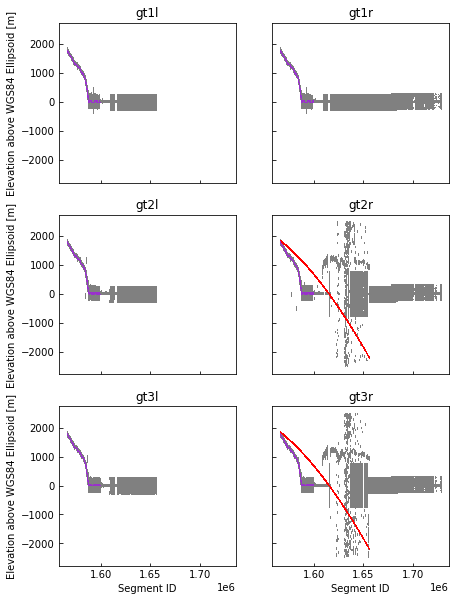

In [5]:
#-- create scatter plot of photon data for all beams
ax = {}
f1,((ax['gt1l'],ax['gt1r']),(ax['gt2l'],ax['gt2r']),(ax['gt3l'],ax['gt3r'])) = \
    plt.subplots(num=1,nrows=3,ncols=2,sharex=True,sharey=True,figsize=(7,10))
for gtx,ax1 in ax.items():
    #-- data for beam gtx
    val = IS2_atl03_mds[gtx]
    #-- segment ID of each photon event
    IDs = np.zeros_like(val['heights']['h_ph'],dtype=np.int)
    for j,idx in enumerate(Segment_Index_begin[gtx]):
        #-- number of photons in segment
        cnt = Segment_PE_count[gtx][j]
        #-- get segment ID of each photon event
        IDs[idx:idx+cnt] = Segment_ID[gtx][j]*np.ones((cnt))
    #-- signal classification confidence
    ice_sig_conf = val['heights']['signal_conf_ph'][:,3]        
    #-- plot all elevations mapped to segment ID
    #-- Photon event lat/lon and elevation (WGS84)
    ax1.plot(IDs,val['heights']['h_ph'],',',c='0.5')
    #-- find TEP events and plot in different color
    isTEP, = np.nonzero(ice_sig_conf == -2)
    ax1.plot(IDs[isTEP],val['heights']['h_ph'][isTEP],',',c='red')
    #-- plot 40m mean elevation of high confidence photons
    ax1.plot(Segment_ID[gtx],Segment_Elev[gtx],',',c='darkorchid')
    #-- set title as beam
    ax1.set_title(gtx)
    #-- adjust ticks
    ax1.get_xaxis().set_tick_params(which='both',direction='in')
    ax1.get_yaxis().set_tick_params(which='both',direction='in')
#-- add x and y labels
for gtx in ['gt3l','gt3r']:
    ax[gtx].set_xlabel('Segment ID')
for gtx in ['gt1l','gt2l','gt3l']:
    ax[gtx].set_ylabel('Elevation above WGS84 Ellipsoid [m]')
#-- show the plot
plt.show()

This particular set of data approaches the grounding line near Thwaites Glacier in West Antarctica, has some photon events that are impacted by the presence of clouds (highly scattered lower confidence photon events), and has some possible Transmitter Echo Photons (TEP) (the red curved line of anomalous photon events in gt2r and gt3r).  These are [things to be aware of when analyzing photon event data from ATL03](https://nsidc.org/sites/nsidc.org/files/technical-references/ATL03_Known_Issues_May2019.pdf).  

The ATLAS instrument decides whether or not to telemeter packets of received photons back as data.  ATLAS uses a digital elevation model (DEM) and a few rules to decide whether to transmit large blocks of data to NASA.  The telemetry bands are evident by the spread of low confidence photon events around the surface for each beam.  

Photon events in ATL03 can come to the ATLAS receiver in a few different ways:  
- Many photons come from the sun either by reflecting off clouds or the land surface.  These photon events are spread in a random distribution along the telemetry band.  In ATL03, a large majority of these "background" photon events are classified, but some may be incorrectly classified as signal.  
- Some photons are from the ATLAS instrument that have reflected off clouds. These photons can be clustered together or widely dispersed depending on the properties of the cloud and a few other variables.  
- Some photons are from the ATLAS instrument that have reflected off the surface (our signal photons).  

There will be photons transmitted by the ATLAS instrument will never be recorded back.  The vast majority of these photons never reached the ATLAS instrument again  (only about 10 out of the 10<sup>14</sup> photons transmitted are received), but some are not detected due to the "dead time" of the instrument.  This can create a bias towards the first photons that were received by the instrument.  This first photon bias (FPB) is estimated in the higher level data products.  

The transmitted pulse is also not symmetric in time, which can introduce a bias when calculating average surfaces.  The magnitude of this bias depends on the shape of the transmitted waveform, the width of the window used to calculate the average surface, and the slope and roughness of the surface that broadens the return pulse.  This transmit-pulse shape bias is also estimated in the higher level data products.  

#### Create a scatter plot of photon elevations vs time
To show the impacts of clouds in more detail, we can investigate the confidence of each photon event for a cloud impacted beam.  For this file, the cloud is situated over the sea surface and does not have an associated confidence for land ice.

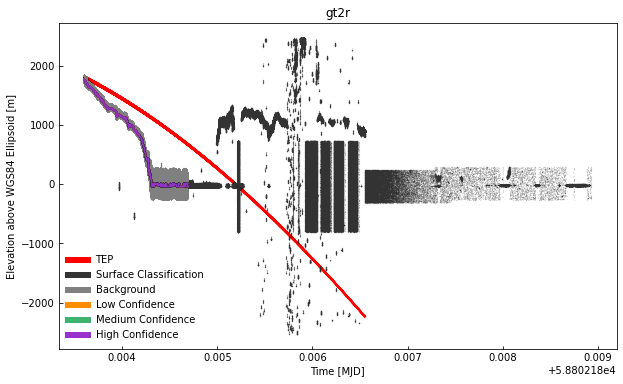

In [6]:
#-- create scatter plot of photon data versus time
f2,ax2 = plt.subplots(num=2,figsize=(10,6))

#-- data for beam gtx
gtx = 'gt2r'
val = IS2_atl03_mds[gtx]

#-- time of each Photon event (PE)
delta_time = val['heights']['delta_time'][:]
gps_seconds = atlas_sdp_gps_epoch + delta_time
time_leaps = count_leap_seconds(gps_seconds)        
#-- calculate time in Modified Julian Days (UTC)
#-- (days since 1858-11-17T00:00:00)
MJD = 44244.0 + (gps_seconds - time_leaps)/86400.0   

#-- check confidence level associated with each photon event
#-- -1: Events not associated with a specific surface type
#--  0: noise
#--  1: buffer but algorithm classifies as background
#--  2: low
#--  3: medium
#--  4: high
#-- Signal classification confidence for land ice
#-- 0=Land; 1=Ocean; 2=SeaIce; 3=LandIce; 4=InlandWater
ice_sig_conf = val['heights']['signal_conf_ph'][:,3]
#-- find possible TEP events
isTEP, = np.nonzero(ice_sig_conf == -2)
#-- find different surface classification photon events
stype, = np.nonzero(ice_sig_conf == -1)
#-- background and buffer photons
bg, = np.nonzero((ice_sig_conf == 0) | (ice_sig_conf == 1))
#-- find photon events of progressively higher confidence
lc, = np.nonzero(ice_sig_conf == 2)
mc, = np.nonzero(ice_sig_conf == 3)
hc, = np.nonzero(ice_sig_conf == 4)
#-- Photon event time and elevation (WGS84)
ax2.plot(MJD[isTEP],val['heights']['h_ph'][isTEP],marker='.',
    markersize=0.1,lw=0,color='red',label='TEP')
ax2.plot(MJD[stype],val['heights']['h_ph'][stype],marker='.',
    markersize=0.1,lw=0,color='0.2',label='Surface Classification')
ax2.plot(MJD[bg],val['heights']['h_ph'][bg],marker='.',
    markersize=0.1,lw=0,color='0.5',label='Background')
ax2.plot(MJD[lc],val['heights']['h_ph'][lc],marker='.',
    markersize=0.1,lw=0,color='darkorange',label='Low Confidence')
ax2.plot(MJD[mc],val['heights']['h_ph'][mc],marker='.',
    markersize=0.1,lw=0,color='mediumseagreen',label='Medium Confidence')
ax2.plot(MJD[hc],val['heights']['h_ph'][hc],marker='.',
    markersize=0.1,lw=0,color='darkorchid',label='High Confidence')
#-- set title and labels
ax2.set_xlabel('Time [MJD]')
ax2.set_ylabel('Elevation above WGS84 Ellipsoid [m]')
ax2.set_title(gtx)
#-- create legend
lgd = ax2.legend(loc=3,frameon=False)
lgd.get_frame().set_alpha(1.0)
for line in lgd.get_lines():
    line.set_linewidth(6)
#-- adjust ticks
ax2.get_xaxis().set_tick_params(which='both',direction='in')
ax2.get_yaxis().set_tick_params(which='both',direction='in')
#-- show the plot
plt.show()

#### Plot 40m mean elevations on a map projection
Here, we visualize our 40m segment elevations spatially.  The surface elevation decreases from the interior of the ice sheet as we approach the coast.  The calculated surface extends over the ocean because the ATL03 classification scheme uses a buffered mask to fully encapsulate the ice sheet.  

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


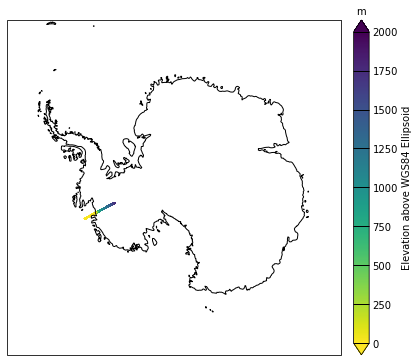

In [7]:
#-- plot ATL03 photon event elevations on a map projection
projection = ccrs.Stereographic(central_longitude=0.0,
    central_latitude=-90,true_scale_latitude=-71.0)
f3,ax3 = plt.subplots(num=3,figsize=(7,5),
    subplot_kw=dict(projection=projection))
#-- scatter plot parameters
vmin,vmax=(0,2000)
cmap = cm.viridis_r
cmap.set_bad(alpha=0.0)
#-- for each beam
for gtx in ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']:
    sc = ax3.scatter(Segment_Lon[gtx],Segment_Lat[gtx],
        c=Segment_Elev[gtx], s=0.1, cmap=cmap,
        vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
ax3.set_aspect('equal', adjustable='box')
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])    
#-- add colorbar
cbar = f2.colorbar(sc,ax=ax3,extend='both',extendfrac=0.0375,
    pad=0.03, drawedges=False)
cbar.solids.set_rasterized(True)
cbar.ax.tick_params(which='both', length=16, width=1, direction='in')
cbar.ax.set_ylabel('Elevation above WGS84 Ellipsoid')
cbar.ax.set_xlabel('m')
cbar.ax.xaxis.set_label_coords(0.50,1.04)
#-- add cartopy coastlines and zoom out
ax3.coastlines('50m')
ax3.set_extent([-180,180,-90,-60],crs=ccrs.PlateCarree())
#-- adjust subplot within figure
f3.subplots_adjust(left=0.02,right=0.85,bottom=0.02,top=0.95)
#-- show the plot
plt.show()

#### Create animation of histograms for a beam
Here, we will look at the photons for a series of 40m segments from a single beam.  The histogram of data here is tightly peaked along the surface of the ice sheet.  Scenarios with rougher or more complex terrain, different surface albedos or different rates of solar insolation can all impact the resultant histograms.  

In [ ]:
#-- create a histogram of the photon heights
f4 = plt.figure(num=4,figsize=(11,5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 2])
ax4 = {}
ax4[0] = plt.subplot(gs[0])
ax4[1] = plt.subplot(gs[1], sharey=ax4[0])
#-- polar stereographic projection
projection = ccrs.Stereographic(central_longitude=0.0,
    central_latitude=-90,true_scale_latitude=-71.0)
ax4[2] = plt.subplot(gs[2], projection=projection)

#-- beam parameters
gtx = 'gt1l'
val = IS2_atl03_mds[gtx]
#-- number of ATL03 segments
n_seg = len(Segment_ID[gtx])

#-- histogram parameters
w = 0.2
vmin,vmax=(900,1900)
b1 = np.arange(vmin,vmax+w,w)
b2 = (b1[1:] + b1[0:-1])/2.0

#-- histogram of photon height
l1, = ax4[0].plot([],[],color='mediumseagreen')
l2, = ax4[0].plot([],[],color='darkorchid')
ax4[0].set_xlim(0,80)
ax4[0].set_ylim(vmin,vmax)
#-- plot of photon height
l3, = ax4[1].plot([],[],'.',color='mediumseagreen')
l4, = ax4[1].plot([],[],'.',color='darkorchid')
ax4[1].set_xlim(0,40)
#-- map of lat/lon location
ax4[2].plot(Segment_Lon[gtx], Segment_Lat[gtx],
    transform=ccrs.PlateCarree(), color='b', zorder=0)
for gt in sorted(set(['gt1l','gt2l','gt3l']) - set([gtx])):
    ax4[2].plot(Segment_Lon[gt], Segment_Lat[gt],
        transform=ccrs.PlateCarree(), color='0.5', zorder=0)
l5, = ax4[2].plot([], [], '.', transform=ccrs.PlateCarree(),
    color='darkorange', ms=5, zorder=1)
#-- set x and y labels
ax4[0].set_xlabel('Photon Event Count')
ax4[0].set_ylabel('Elevation above WGS84 Ellipsoid [m]')
ax4[1].set_xlabel('Along-Track Distance [m]')
#-- adjust ticks
plt.setp(ax4[1].get_yticklabels(), visible=False)
ax4[0].get_xaxis().set_tick_params(which='both',direction='in')
ax4[0].get_yaxis().set_tick_params(which='both',direction='in')
ax4[1].get_xaxis().set_tick_params(which='both',direction='in')
ax4[1].get_yaxis().set_tick_params(which='both',direction='in')
#-- add cartopy coastlines and zoom out
ax4[2].coastlines('50m')
ax4[2].set_extent([-180,180,-90,-60],crs=ccrs.PlateCarree())
#-- set title as beam
ttl = f4.suptitle(None)
#-- adjust subplot within figure
f4.subplots_adjust(left=0.1,right=0.95,bottom=0.1,top=0.925,wspace=0.1)

#-- animate every 50th segment
def animate_segments(i):
    #-- index for segment j
    j = 50*i
    idx = val['geolocation']['ph_index_beg'][j] - 1
    #-- number of photons in segment (use 2 ATL03 segments)
    c1 = np.copy(val['geolocation']['segment_ph_cnt'][j])
    c2 = np.copy(val['geolocation']['segment_ph_cnt'][j+1])
    cnt = c1 + c2
    #-- along-track X and Y coordinates    
    distance_along_X = np.copy(val['heights']['dist_ph_along'][idx:idx+cnt])
    distance_along_X[c1:] += Segment_Length[gtx][j]
    distance_along_Y = np.copy(val['heights']['dist_ph_across'][idx:idx+cnt])
    #-- photon height for segment
    h_ph = val['heights']['h_ph'][idx:idx+cnt]
    #-- latitude and longitude of segment
    segment_lats = val['heights']['lat_ph'][idx:idx+cnt]
    segment_lons = val['heights']['lon_ph'][idx:idx+cnt]
    #-- land ice signal confidence for segment
    ice_sig_conf = val['heights']['signal_conf_ph'][idx:idx+cnt,3]
    bg, = np.nonzero(ice_sig_conf <= 1)
    mc, = np.nonzero(ice_sig_conf >= 2)
    #-- histogram using numpy
    hbg,bbg = np.histogram(h_ph[bg],bins=b1)
    hmc,bmc = np.histogram(h_ph[mc],bins=b1)
    #-- set data for each empty plot
    l1.set_data(hbg,b2)
    l2.set_data(hmc,b2)
    l3.set_data(distance_along_X[bg],h_ph[bg])
    l4.set_data(distance_along_X[mc],h_ph[mc])
    l5.set_data(segment_lons, segment_lats)
    #-- set title text
    args = (PRD,YY,MM,DD,TRK,gtx,Segment_ID[gtx][j+1])
    ttl.set_text(('{0} {1}-{2}-{3}\tTrack {4}\tBeam {5}'
        '\tSegment {6:d}').format(*args).expandtabs())

#-- set animation
anim = animation.FuncAnimation(f4, animate_segments, frames=300)
%matplotlib inline
HTML(anim.to_jshtml())